# Extrapolation, 1

Can a robot do something it wasn't trained to do? Conventional wisdom says that neural networks work fine when **interpolating** between their training instances. However, they can't **extrapolate**. That is, neural networks cannot appropriately perform when placed in a region outside their trained experience. This notebook explores that notion.

## Experiment

In this experiment, we create a robot with a single sonar sensor facing forward. The robot starts at the end of a hallway, and approaches a target location halfway down a long hallway.

In [1]:
from conx import *
from jyro.simulator import *
import math
import time

Using Theano backend.
conx, version 3.5.6


We make an 8m x 2m room, with the robot at the far right end facing to the left. The sonar sensor faces forward and has a max range of 6m. We give the robot a camera just so that we can see the simulated world from the robot's perspective.

In [2]:
def make_world(physics):
    physics.addBox(0, 0, 8, 2, fill="backgroundgreen", wallcolor="gray")

MAX_SENSOR_DISTANCE = 6 # meters
    
def make_robot():
    robot = Pioneer("Pioneer", 7.5, 1, math.pi/2)  #parameters are x, y, heading (in radians)
    robot.addDevice(PioneerFrontSonar(MAX_SENSOR_DISTANCE))
    robot.addDevice(Camera())
    return robot

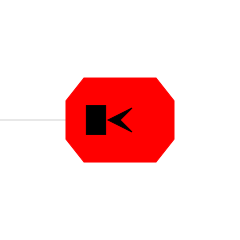

In [3]:
robot = make_robot()
robot

We write a function that provides a teacher to drive the robot. The closer it gets to the target location, the slower the robot moves. The function returns a list of (sensor, power) pairs where the sensor is a scaled distance reading of the sensor, and power is how fast the robot should move given the sensor reading.

In [4]:
def collect_data(simulator):
    data = []
    simulator.reset() # put robot back to where it is defined
    while True:
        scaled_dist = simulator.robot["sonar"].getData()[0]/MAX_SENSOR_DISTANCE
        # The power is a function of distance:
        power = 1.0 - ((1 - scaled_dist)/0.33 * 0.9) 
        robot.move(power, 0)
        data.append([scaled_dist, [power]])
        simulator.step()
        time.sleep(.1) # don't overwhelm the network
        if power < 0.05:
            break
    return data

We create a visual simulation in order to watch what the robot does.

In [5]:
sim = VSimulator(robot, make_world, size=(700, 180))

VBox(children=(VBox(children=(HBox(children=(Checkbox(value=True, description='Update GUI'), Checkbox(value=False, description='Trace Path'), Text(value='0.0 seconds', description='Time:'))), HBox(children=(VBox(children=(HBox(children=(FloatSlider(value=0.0, layout=Layout(height='180px', padding='0px 0px 0px 0px', width='15px'), orientation='vertical', readout=False), HTML(value='<svg baseProfile="full" height="180" version="1.1" width="700" xmlns="http://www.w3.org/2000/svg" xmlns:ev="http://www.w3.org/2001/xml-events" xmlns:xlink="http://www.w3.org/1999/xlink"><defs /><rect fill="#eef3dd" height="175.0" stroke="#bebebe" stroke-width="1" width="700.0" x="0.0" y="0.0" /><line fill="#800080" stroke="#d3d3d3" stroke-width="1" x1="656.25" x2="131.25" y1="87.5" y2="87.49999999999996" /><line fill="#800080" stroke="#a020f0" stroke-width="1" x1="656.25" x2="605.7318512251488" y1="87.5" y2="175.0" /><line fill="#800080" stroke="#a020f0" stroke-width="1" x1="656.25" x2="605.7318512251488" y1="87.5" y2="0.0" /><polygon fill="red" points="636.5625,94.5 643.125,102.8125 669.375,102.8125 675.9375,94.5 675.9375,80.5 669.375,72.1875 643.125,72.1875 636.5625,80.5" stroke="red" stroke-width="1" /><polygon points="-4.375,-4.375 0,0 4.375,-4.375 0,4.375" stroke="black" stroke-width="1" transform="translate(656.25,87.5) rotate(90.0)" /><polygon fill="black" points="644.0,82.25 651.0,82.25 651.0,92.75 644.0,92.75" stroke="black" stroke-width="1" /></svg>'))), FloatSlider(value=0.0, layout=Layout(height='15px', padding='0px 0px 0px 10px', width='720px'), readout=False)), layout=Layout(height='240px')), VBox(children=(HTML(value='<img style="image-rendering: pixelated;" src="data:image/gif;base64,R0lGODdhPAAoAIcAAO7z3a3Y5qioqKenp6ampqWlpaSkpKOjo6KioqGhoaCgoJ6enp2dnZubm5mZmZeXl5SUlJGRkY6OjomJiYSEhH5+fnV1dWpqalxcXEZGRi8vLy4uLgAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAACwAAAAAPAAoAEAI/wADCBxIsKDBgwgTKlzIsKHDhwIGDCBQoICBAwgSKFjAoIGDBxAiSJhAoYKFAChTqlRpoQKFCRIiQHjgoAGDBQoSIDhgoEABAgMGCBAwYACBAgUMHECQQMECBg0cPIAQQcIEChUAaN3KtSuAChQmSIgA4YGDBgwWKEiA4ICBAgUIDBggAIDdu3jz6t3Lt6/fvAECCx5MuLDhw4gTExYwYACBAgUCSJ5MubLly5gzTy5QgMCAAQIEDBhAoEABAwcQJFCwgEEDBw8gRJAwgUIFCxcwZNiwQYNvDRs2ZMBwwUIFChMkRIDwwEEDBgsUJEBwwECBAgQGDBAAoLv37+DDi/8fT768+fPo06sPwL69+/fw48ufT7++/fv48+vfz3++AIADBhAoUMDAAQQJFCxg0MDBAwgRJASgWNHiRYwBJESA8MBBAwYLFCRAcMBAgQIEBgwQIGDAAAIFChg4gCCBggUMGjh4ACGChAkUKli4gCHAUaRJMVywUIHCBAkRIDxw0IDBAgUJEBwwUKAAgQEDBAgYMIBAgQIGDiBIoGABgwYOHkCIIGEChQoWLmAA0NfvXwwXLFSgMEFCBAgPHDRgsEBBAgQHDBQoQGDAAAECBgwgUKCAgQMIEihYwKCBgwcQAKxm3dr1a9cQHjhowGCBggQIDhgoUIDAgAECAAwnXtz/+HHkyZUvZ97c+XPo0aVPVx7A+nXs2bVv597d+3fw4cWPJ1/e/Hn06dWvZ9/efXcBAwYQKFDAwAEECRQsYNDAAcAAAgcSLGjwoEAHDRgsUJAAwQEDBQoQGDBAgIABAwgUKGDgAIIEChYwaODgAYQIEiZQCODyJcyYLylMkBABwgMHDRgsUJAAwQEDBQoQGDBAgIABAwgUKGDgAIIEChYwaODgAYQIEiZQqGDhQoCwYseGvWChAoUJEiJAeOCgAYMFChIgOGCgQAECAwYIEDBgAIECBQwcQJBAwQIGDRw8gBBBwgQKFSxcwJBhwwYNmjVs2JABwwULFShMkBABwgMH/w0YLFCQAMEBAwUKEBgwQICAAQMIFChg4ACCBAoWMGjg4AGECBImUKhg4QKGDACmU5+eAcMFCxUoTJAQAcIDBw0YLFCQAMEBAwUKEBgwQICAAQMIFChg4ACCBAoWMGjgAOADCBEkTKBQwcIFAAsZNlx4wUIFChMkRIDwwEEDBgsUJEBwwECBAgQGDBAgYMAAAgUKGDiAIIGCBQwaOHgAIYK

Now, we collect the data:

In [6]:
data = collect_data(sim)

We note that the simulator ran for 8.10 seconds, and if it collects a pair of (sensor, power) for every 1/10 of a second, it should have 81 pairs:

In [7]:
len(data)

81

We visualize the collected data:

In [8]:
train = ["Training Data", [pair[1][0] for pair in data]]

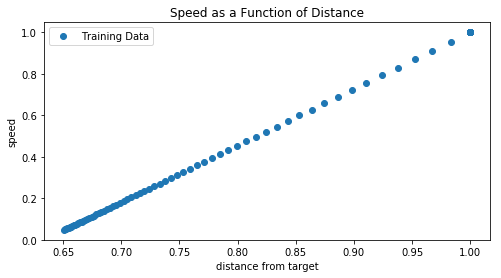

In [9]:
plot(train, 
     title="Speed as a Function of Distance",
     xlabel="distance from target",
     ylabel="speed",
     xs=[pair[0] for pair in data], default_symbol="o")

## Neural Network

Now, we will use the data to train a neural network. The network will have 1-unit in the input layer (for the scaled distance reading), a hidden layer, and a 1-unit output layer to produce the power value.

In [10]:
net = Network("Go To Target")
net.add(Layer("input", 1))
net.add(Layer("hidden", 10, activation="sigmoid"))
net.add(Layer("output", 1, activation = "linear"))
net.connect()
net.compile(loss="mse", optimizer=SGD(lr=.1, momentum=.5))
net.model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           (None, 1)                 0         
_________________________________________________________________
hidden (Dense)               (None, 10)                20        
_________________________________________________________________
output (Dense)               (None, 1)                 11        
Total params: 31
Trainable params: 31
Non-trainable params: 0
_________________________________________________________________


We load the collected data into the network:

In [11]:
net.dataset.load(data)
net.dataset.summary()

Input Summary:
   count  : 81 (81 for training, 0 for testing)
   shape  : [()]
   range  : (0.6511592, 1.0)
Target Summary:
   count  : 81 (81 for training, 0 for testing)
   shape  : [(1,)]
   range  : (0.048616093, 1.0)


In [12]:
net.dashboard()

Dashboard(children=(Accordion(children=(HBox(children=(VBox(children=(Select(description='Dataset:', index=1, options=('Test', 'Train'), rows=1, value='Train'), FloatSlider(value=1.0, continuous_update=False, description='Zoom', max=3.0, min=0.5), IntText(value=150, description='Horizontal space between banks:', style=DescriptionStyle(description_width='initial')), IntText(value=30, description='Vertical space between layers:', style=DescriptionStyle(description_width='initial')), HBox(children=(Checkbox(value=False, description='Show Targets', style=DescriptionStyle(description_width='initial')), Checkbox(value=False, description='Errors', style=DescriptionStyle(description_width='initial')))), Select(description='Features:', options=('',), rows=1, value=''), IntText(value=3, description='Feature columns:', style=DescriptionStyle(description_width='initial')), FloatText(value=2.0, description='Feature scale:', style=DescriptionStyle(description_width='initial'))), layout=Layout(width='100%')), VBox(children=(Select(description='Layer:', index=2, options=('input', 'hidden', 'output'), rows=1, value='output'), Checkbox(value=True, description='Visible'), Select(description='Colormap:', options=('', 'Accent', 'Accent_r', 'Blues', 'Blues_r', 'BrBG', 'BrBG_r', 'BuGn', 'BuGn_r', 'BuPu', 'BuPu_r', 'CMRmap', 'CMRmap_r', 'Dark2', 'Dark2_r', 'GnBu', 'GnBu_r', 'Greens', 'Greens_r', 'Greys', 'Greys_r', 'OrRd', 'OrRd_r', 'Oranges', 'Oranges_r', 'PRGn', 'PRGn_r', 'Paired', 'Paired_r', 'Pastel1', 'Pastel1_r', 'Pastel2', 'Pastel2_r', 'PiYG', 'PiYG_r', 'PuBu', 'PuBuGn', 'PuBuGn_r', 'PuBu_r', 'PuOr', 'PuOr_r', 'PuRd', 'PuRd_r', 'Purples', 'Purples_r', 'RdBu', 'RdBu_r', 'RdGy', 'RdGy_r', 'RdPu', 'RdPu_r', 'RdYlBu', 'RdYlBu_r', 'RdYlGn', 'RdYlGn_r', 'Reds', 'Reds_r', 'Set1', 'Set1_r', 'Set2', 'Set2_r', 'Set3', 'Set3_r', 'Spectral', 'Spectral_r', 'Vega10', 'Vega10_r', 'Vega20', 'Vega20_r', 'Vega20b', 'Vega20b_r', 'Vega20c', 'Vega20c_r', 'Wistia', 'Wistia_r', 'YlGn', 'YlGnBu', 'YlGnBu_r', 'YlGn_r', 'YlOrBr', 'YlOrBr_r', 'YlOrRd', 'YlOrRd_r', 'afmhot', 'afmhot_r', 'autumn', 'autumn_r', 'binary', 'binary_r', 'bone', 'bone_r', 'brg', 'brg_r', 'bwr', 'bwr_r', 'cool', 'cool_r', 'coolwarm', 'coolwarm_r', 'copper', 'copper_r', 'cubehelix', 'cubehelix_r', 'flag', 'flag_r', 'gist_earth', 'gist_earth_r', 'gist_gray', 'gist_gray_r', 'gist_heat', 'gist_heat_r', 'gist_ncar', 'gist_ncar_r', 'gist_rainbow', 'gist_rainbow_r', 'gist_stern', 'gist_stern_r', 'gist_yarg', 'gist_yarg_r', 'gnuplot', 'gnuplot2', 'gnuplot2_r', 'gnuplot_r', 'gray', 'gray_r', 'hot', 'hot_r', 'hsv', 'hsv_r', 'inferno', 'inferno_r', 'jet', 'jet_r', 'magma', 'magma_r', 'nipy_spectral', 'nipy_spectral_r', 'ocean', 'ocean_r', 'pink', 'pink_r', 'plasma', 'plasma_r', 'prism', 'prism_r', 'rainbow', 'rainbow_r', 'seismic', 'seismic_r', 'spectral', 'spectral_r', 'spring', 'spring_r', 'summer', 'summer_r', 'tab10', 'tab10_r', 'tab20', 'tab20_r', 'tab20b', 'tab20b_r', 'tab20c', 'tab20c_r', 'terrain', 'terrain_r', 'viridis', 'viridis_r', 'winter', 'winter_r'), rows=1, value=''), HTML(value='<img src="data:image/gif;base64,R0lGODdhLAEZAIcAAPEBAY8AAM8AAAEB8q8AAAAAbwAAsAAAkAAA0PTo8vr3+wAAV0dH/7e3//9WVv/W1hYW/zQ0/2dn/4aG/6Sk/9nZ//8XF/82Nv9oaP+Xl/+1tSQk/1lZ/3h4/5SU/8nJ//8mJv9ERP95ef+Hh/+mpv/ExH8AAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAA

<IPython.core.display.Javascript object>

And now, we train the network on the given data:

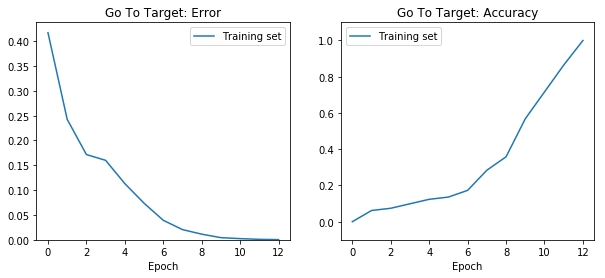

In [13]:
if net.saved():
    net.load()
    net.plot_results()
else:
    net.train(400, accuracy=1.0, tolerance=0.05, batch_size=1, save=True, plot=True)

This is a fairly straightforward problem for the network to solve. If it doesn't get 100% accuracy, you may wish to:

```python
net.delete()
net.reset()
```
and try training again by running the previous cell.

## Testing the Network

In [14]:
test = ["Network", [net.propagate(pair[0])[0] for pair in data]]

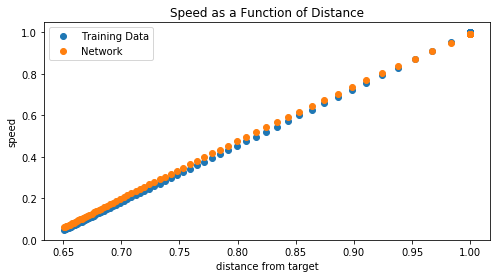

In [15]:
plot([train, test], 
     title="Speed as a Function of Distance",
     xlabel="distance from target",
     ylabel="speed",
     default_symbol="o",
     xs=[pair[0] for pair in data])

## Network-Controlled Robot

In [16]:
def net_brain(robot):
    scaled_distance = robot["sonar"].getData()[0]/6
    output = net.propagate([scaled_distance])[0]
    robot.move(output, 0)
    outputs.append([scaled_distance, output])
    history.append(robot.getPose())
        
robot.brain = net_brain

In [17]:
outputs = []
history = []
sim.reset()
sim.display()

VBox(children=(VBox(children=(HBox(children=(Checkbox(value=True, description='Update GUI'), Checkbox(value=False, description='Trace Path'), Text(value='0.00 seconds', description='Time:'))), HBox(children=(VBox(children=(HBox(children=(FloatSlider(value=50.0, layout=Layout(height='180px', padding='0px 0px 0px 0px', width='15px'), orientation='vertical', readout=False), HTML(value='<svg baseProfile="full" height="180" version="1.1" width="700" xmlns="http://www.w3.org/2000/svg" xmlns:ev="http://www.w3.org/2001/xml-events" xmlns:xlink="http://www.w3.org/1999/xlink"><defs /><rect fill="#eef3dd" height="175.0" stroke="#bebebe" stroke-width="1" width="700.0" x="0.0" y="0.0" /><line fill="#800080" stroke="#d3d3d3" stroke-width="1" x1="656.25" x2="131.25" y1="87.5" y2="87.49999999999996" /><line fill="#800080" stroke="#a020f0" stroke-width="1" x1="656.25" x2="605.7318512251488" y1="87.5" y2="175.0" /><line fill="#800080" stroke="#a020f0" stroke-width="1" x1="656.25" x2="605.7318512251488" y1="87.5" y2="0.0" /><polygon fill="red" points="636.5625,94.5 643.125,102.8125 669.375,102.8125 675.9375,94.5 675.9375,80.5 669.375,72.1875 643.125,72.1875 636.5625,80.5" stroke="red" stroke-width="1" /><polygon points="-4.375,-4.375 0,0 4.375,-4.375 0,4.375" stroke="black" stroke-width="1" transform="translate(656.25,87.5) rotate(90.0)" /><polygon fill="black" points="644.0,82.25 651.0,82.25 651.0,92.75 644.0,92.75" stroke="black" stroke-width="1" /></svg>'))), FloatSlider(value=93.75, layout=Layout(height='15px', padding='0px 0px 0px 10px', width='720px'), readout=False)), layout=Layout(height='240px')), VBox(children=(HTML(value='<img style="image-rendering: pixelated;" src="data:image/gif;base64,R0lGODdhPAAoAIcAAO7z3a3Y5qioqKenp6ampqWlpaSkpKOjo6KioqGhoaCgoJ6enp2dnZubm5mZmZeXl5SUlJGRkY6OjomJiYSEhH5+fnV1dWpqalxcXEZGRi8vLy4uLgAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAACwAAAAAPAAoAEAI/wADCBxIsKDBgwgTKlzIsKHDhwIGDCBQoICBAwgSKFjAoIGDBxAiSJhAoYKFAChTqlRpoQKFCRIiQHjgoAGDBQoSIDhgoEABAgMGCBAwYACBAgUMHECQQMECBg0cPIAQQcIEChUAaN3KtSuAChQmSIgA4YGDBgwWKEiA4ICBAgUIDBggAIDdu3jz6t3Lt6/fvAECCx5MuLDhw4gTExYwYACBAgUCSJ5MubLly5gzTy5QgMCAAQIEDBhAoEABAwcQJFCwgEEDBw8gRJAwgUIFCxcwZNiwQYNvDRs2ZMBwwUIFChMkRIDwwEEDBgsUJEBwwECBAgQGDBAAoLv37+DDi/8fT768+fPo06sPwL69+/fw48ufT7++/fv48+vfz3++AIADBhAoUMDAAQQJFCxg0MDBAwgRJASgWNHiRYwBJESA8MBBAwYLFCRAcMBAgQIEBgwQIGDAAAIFChg4gCCBggUMGjh4ACGChAkUKli4gCHAUaRJMVywUIHCBAkRIDxw0IDBAgUJEBwwUKAAgQEDBAgYMIBAgQIGDiBIoGABgwYOHkCIIGEChQoWLmAA0NfvXwwXLFSgMEFCBAgPHDRgsEBBAgQHDBQoQGDAAAECBgwgUKCAgQMIEihYwKCBgwcQAKxm3dr1a9cQHjhowGCBggQIDhgoUIDAgAECAAwnXtz/+HHkyZUvZ97c+XPo0aVPVx7A+nXs2bVv597d+3fw4cWPJ1/e/Hn06dWvZ9/efXcBAwYQKFDAwAEECRQsYNDAAcAAAgcSLGjwoEAHDRgsUJAAwQEDBQoQGDBAgIABAwgUKGDgAIIEChYwaODgAYQIEiZQCODyJcyYLylMkBABwgMHDRgsUJAAwQEDBQoQGDBAgIABAwgUKGDgAIIEChYwaODgAYQIEiZQqGDhQoCwYseGvWChAoUJEiJAeOCgAYMFChIgOGCgQAECAwYIEDBgAIECBQwcQJBAwQIGDRw8gBBBwgQKFSxcwJBhwwYNmjVs2JABwwULFShMkBABwgMH/w0YLFCQAMEBAwUKEBgwQICAAQMIFChg4ACCBAoWMGjg4AGECBImUKhg4QKGDACmU5+eAcMFCxUoTJAQAcIDBw0YLFCQAMEBAwUKEBgwQICAAQMIFChg4ACCBAoWMGjgAOADCBEkTKBQwcIFAAsZNlx4wUIFChMkRIDwwEEDBgsUJEBwwECBAgQGDBAgYMAAAgUKGDiAIIGCBQwaOHg

**Before continuing**, run the experiment above:

1. Press the play button until robot is done moving
2. Press the stop button

In [18]:
trained_range = ["Network interpolation", outputs]

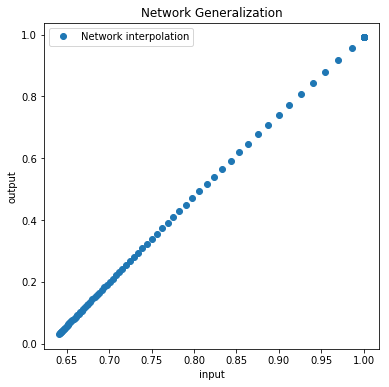

In [19]:
scatter(trained_range,
       title="Network Generalization", 
        xlabel="input", ylabel="output", default_symbol="o")

In [20]:
len(history)

89

Let's make a little movie of the trained experience:

In [21]:
def replay_history(index):
    pose = history[index]
    robot.setPose(*pose)
    sim.update()
    return sim.canvas.render(format="pil")

In [22]:
movie(replay_history, "generalize-in-range.gif", (0, len(history)))

Now, the big question: what does the robot do in positions where t wasn't trained? How does it extrapolate?

To test this, we put the robot in a novel location, and re-run the experiment. (You can skip this next cell, and manually put the robot in any position you wish).

In [23]:
robot.setPose(.5, 1)
sim.update_gui()

First, we reset the variables:

In [28]:
outputs = []
history = []
sim.display()

VBox(children=(VBox(children=(HBox(children=(Checkbox(value=True, description='Update GUI'), Checkbox(value=False, description='Trace Path'), Text(value='16.60 seconds', description='Time:'))), HBox(children=(VBox(children=(HBox(children=(FloatSlider(value=50.0, layout=Layout(height='180px', padding='0px 0px 0px 0px', width='15px'), orientation='vertical', readout=False), HTML(value='<svg baseProfile="full" height="180" version="1.1" width="700" xmlns="http://www.w3.org/2000/svg" xmlns:ev="http://www.w3.org/2001/xml-events" xmlns:xlink="http://www.w3.org/1999/xlink"><defs /><rect fill="#eef3dd" height="175.0" stroke="#bebebe" stroke-width="1" width="700.0" x="0.0" y="0.0" /><line fill="#800080" stroke="#add8e6" stroke-width="1" x1="324.70686435699463" x2="0.0" y1="87.5" y2="87.5" /><line fill="#800080" stroke="#a020f0" stroke-width="1" x1="324.70686435699463" x2="274.1887175018192" y1="87.5" y2="175.0" /><line fill="#800080" stroke="#a020f0" stroke-width="1" x1="324.70686435699463" x2="274.1887175018192" y1="87.5" y2="0.0" /><polygon fill="red" points="305.01936435699463,94.5 311.58186435699463,102.8125 337.83186435699463,102.8125 344.39436435699463,94.5 344.39436435699463,80.5 337.83186435699463,72.1875 311.58186435699463,72.1875 305.01936435699463,80.5" stroke="red" stroke-width="1" /><polygon points="-4.375,-4.375 0,0 4.375,-4.375 0,4.375" stroke="black" stroke-width="1" transform="translate(324.70686435699463,87.5) rotate(90.0)" /><polygon fill="black" points="312.45686435699463,82.25 319.45686435699463,82.25 319.45686435699463,92.75 312.45686435699463,92.75" stroke="black" stroke-width="1" /></svg>'))), FloatSlider(value=46.38669490814209, layout=Layout(height='15px', padding='0px 0px 0px 10px', width='720px'), readout=False)), layout=Layout(height='240px')), VBox(children=(HTML(value='<img style="image-rendering: pixelated;" src="data:image/gif;base64,R0lGODdhPAAoAIcAAO7z3a3Y5qioqKenp6ampqWlpaSkpKOjo6KioqGhoaCgoJ6enp2dnZubm5mZmZeXl5SUlJGRkY6OjomJiYSEhH5+fnd3d3Z2dnV1dQAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAACwAAAAAPAAoAEAI/wADCBxIsKDBgwgTKlzIsKHDhwIGDCBQoICBAwgSKFjAoIGDBxAiSJhAoQIGDBdSWljJ8oJLDBgqUJggIQKEBw4aMFigIAGCAwYKFCAwYIAAAQMGEChQwMABBAkULGDQwMEDCBEkTKBQAYDXr2DDAqhAYYKECBAeOGjAYIGCBAgOGChQgMCAAQIA6N3Lt6/fv4ADC+4boLDhw4gTK17MuDFiAQMGEChQIIDly5gza97MufPlAgUIDBggQMCAAQQKFDBwAEECBQsYNHDwAEIECRMoVMCA4YJvC8CDXxiOAUMFChMkRIDwwEEDBgsUJEBwwECBAgQGDBAAoLv37+DDi/8fT768+fPo06sPwL69+/fw48ufT7++/fv48+vfz3++AIADBhAoUMDAAQQJFCxg0MDBAwgRJASgWNHiRYwBJESA8MBBAwYLFCRAcMBAgQIEBgwQIGDAAAIFChg4gCCBggUMGjh4ACGChAkUKmDAcMGoBaRJLyzFgKEChQkSIkB44KABgwUKEiA4YKBAAQIDBggQMGAAgQIFDBxAkEDBAgYNHDyAEEHCBAoVMGC40NfCX8AXBGPAUIHCBAkRIDxw0IDBAgUJEBwwUKAAgQEDBAgYMIBAgQIGDiBIoGABgwYOHkAA0Nr1a9ixYUN44KABgwUKEiA4YKBAAQIDBggAUNz/+HHkyZUvZ97c+XPo0aVPp16deQDs2bVv597d+3fw4cWPJ1/e/Hn06dWvZ9/e/Xv43wUMGECgQAEDBxAkULCAAcAGDgIQLGjwIMKEBB00YLBAQQIEBwwUKEBgwAABAgYMIFCggIEDCBIoWMCggYMHECJImEAhAMyYMmfGpDBBQgQIDxw0YLBAQQIEBwwUKEBgwAABAgYMIFCggIEDCBIoWMCggYMHECJImEChAgYMF8ZaKGv2AloMGCpQmCAhAoQHDhowWKAgAYIDBgoUIDBggAABAwYQKFDAwAEECRQsYNDAwQMIESRMoFABA4YLmi1w7nzhMwYMFShMkBABwgMH/w0YLFCQAMEBAwUKEBgwQICAAQMIFC

Take a look at the simulation above. What will the robot do? What is a reasonable action to make?

Let's find out what the robot does.

**Before continuing**, run the experiment above:

1. Press the play button until robot is done moving
2. Press the stop button

In [25]:
movie(replay_history, "generalize-out-range.gif", (0, len(history)))

In [29]:
untrained_range = ["Network extrapolation", outputs]

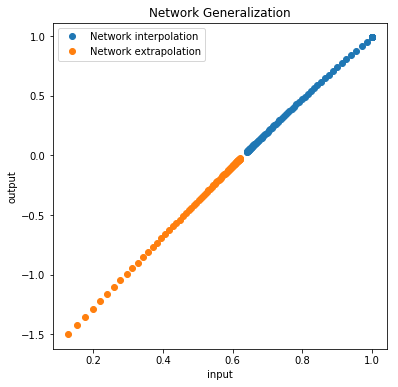

In [30]:
scatter([trained_range, untrained_range],
        title="Network Generalization", 
        xlabel="input", ylabel="output", default_symbol="o")

## Conclusion

The robot was tested in a region for which there was no training data, and so it had to **extrapolate** from what it knew, to a novel scenario. It did. Although it had never been trained to move backwards, it was able to determine that the correct action was to move backwards. In fact, it shows that the further the robot is from the target location, the faster it moves towards it.

How was the robot able to extrapolate beyond its training? Well, the network's ability to move backwards when it was never trained to do so is a bit of an overstatement of what the network is doing. Because the output is a single unit for "power" and he robot can be driven by a single value with negative meaning to backup and positive meaning to move forward, it really doesn't make a distinction between forward/backward... it merely converts the distance into a value. 

However, the network has done what has been claimed to be impossible, albeit in a simple fashion. What this suggests is that extrapolation to unknown regions may be possible, if the space of actions is arranged in a proper way.